# Dynamic filter MNIST classification

Note: This notebook is desinged to run with GPU runtime.

Import modules and set random seeds.

In [1]:
import os, random
os.environ['PYTHONHASHSEED']=str(20230515)
random.seed(20230515)

import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist

np.random.seed(20190222)
tf.random.set_seed(20190222)

Download the MNIST dataset and store into NumPy arrays.

In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape(
                  (len(train_images), 784)).astype('float32') / 255
test_images = test_images.reshape(
                  (len(test_images), 784)).astype('float32') / 255
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

Define the CNN model with a single convolutional filter layer.

In [3]:
model = models.Sequential(name='CNN_model')
model.add(layers.Reshape((28, 28, 1), input_shape=(28*28,), name='reshape'))
model.add(layers.Conv2D(16, (5, 5), padding='same', strides=(2, 2),
                        use_bias=True, activation='relu', name='conv_filter'))
model.add(layers.Flatten(name='flatten'))
model.add(layers.Dense(1024, activation='relu', name='hidden'))
model.add(layers.Dense(10, activation='softmax', name='softmax'))

model.summary()

Model: "CNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv_filter (Conv2D)        (None, 14, 14, 16)        416       
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 hidden (Dense)              (None, 1024)              3212288   
                                                                 
 softmax (Dense)             (None, 10)                10250     
                                                                 
Total params: 3,222,954
Trainable params: 3,222,954
Non-trainable params: 0
_________________________________________________________________


Compile the model using the Adam optimizer, and Categorical crossentroy as a loss function.

In [4]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

Train the model. It achieves around 98% accuracy.

In [5]:
history = model.fit(train_images, train_labels,
                    validation_data=(test_images, test_labels),
                    batch_size=128, epochs=10)

Epoch 1/10
469/469 [==============================] - 10s 9ms/step - loss: 0.1925 - acc: 0.9441 - val_loss: 0.0676 - val_acc: 0.9795
Epoch 2/10
469/469 [==============================] - 5s 10ms/step - loss: 0.0571 - acc: 0.9821 - val_loss: 0.0576 - val_acc: 0.9817
Epoch 3/10
469/469 [==============================] - 3s 5ms/step - loss: 0.0324 - acc: 0.9896 - val_loss: 0.0530 - val_acc: 0.9831
Epoch 4/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0207 - acc: 0.9935 - val_loss: 0.0423 - val_acc: 0.9856
Epoch 5/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0136 - acc: 0.9956 - val_loss: 0.0473 - val_acc: 0.9847
Epoch 6/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0098 - acc: 0.9969 - val_loss: 0.0508 - val_acc: 0.9857
Epoch 7/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0075 - acc: 0.9978 - val_loss: 0.0500 - val_acc: 0.9857
Epoch 8/10
469/469 [==============================] - 3s 6ms/step - loss: 

Plot charts for the accuracy and loss values.

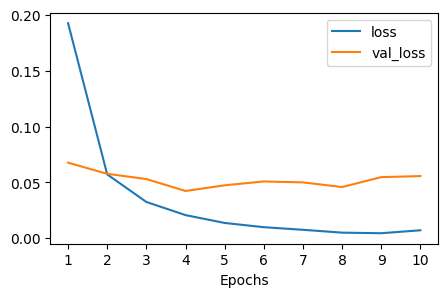

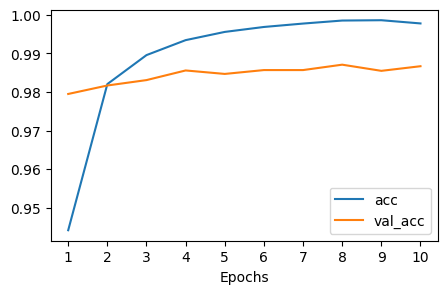

In [6]:
df = DataFrame({'loss': history.history['loss'],
               'val_loss': history.history['val_loss']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(5, 3))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)

df = DataFrame({'acc': history.history['acc'],
               'val_acc': history.history['val_acc']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(5, 3))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)

Apply the trained filters to the MNIST dataset.

In [7]:
model2 = models.Model(inputs=model.input,
                      outputs=model.get_layer('conv_filter').output)

conv_output = model2.predict(test_images[:9], verbose=0)
filter_vals = model.get_layer('conv_filter').get_weights()[0]

Show images after applying the convolutional filters.

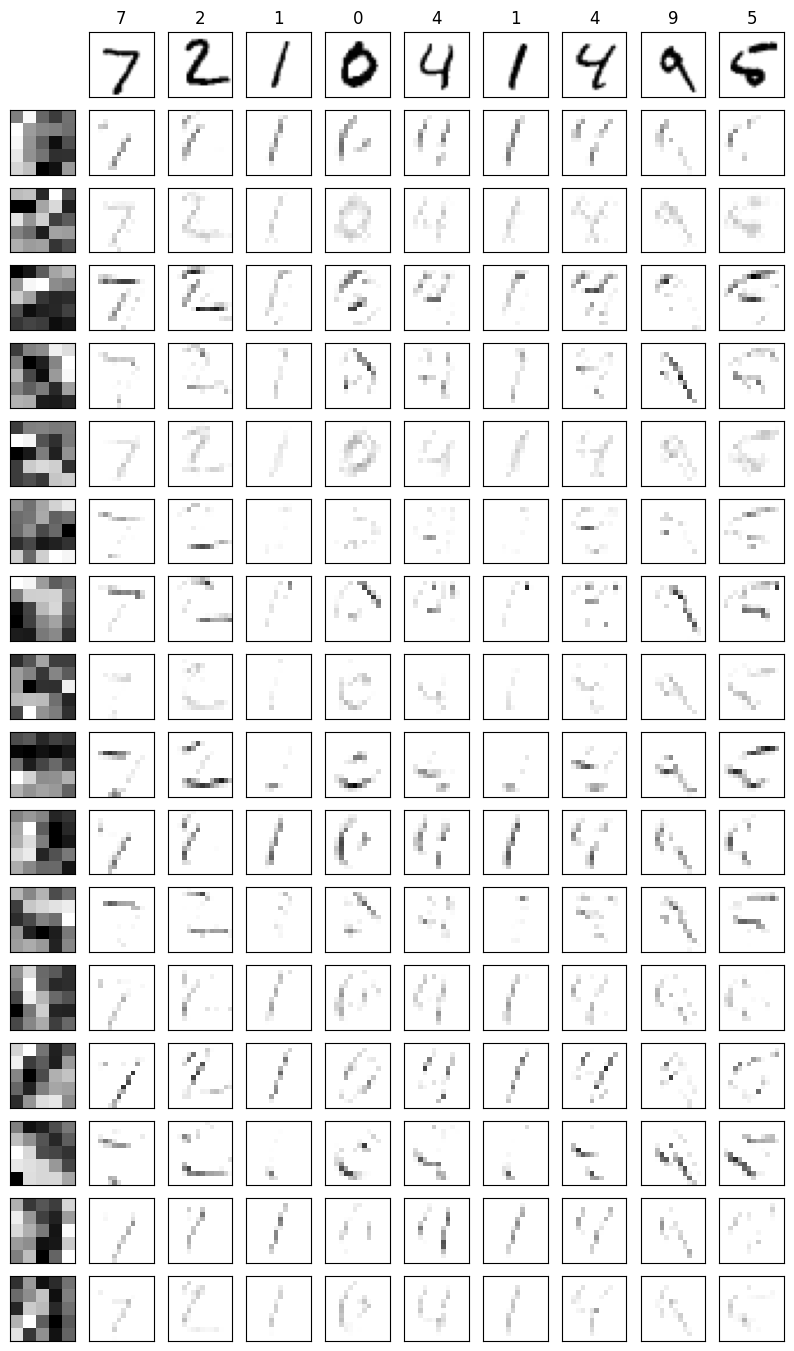

In [8]:
num_filters = 16
fig = plt.figure(figsize=(10, num_filters+1))
v_max = np.max(conv_output)

for i in range(num_filters):
    subplot = fig.add_subplot(num_filters+1, 10, 10*(i+1)+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(filter_vals[:,:,0,i], cmap=plt.cm.gray_r)

for i in range(9):
    subplot = fig.add_subplot(num_filters+1, 10, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('{}'.format(np.argmax(test_labels[i])))
    subplot.imshow(test_images[i].reshape((28,28)),
                   vmin=0, vmax=1, cmap=plt.cm.gray_r)

    for f in range(num_filters):
        subplot = fig.add_subplot(num_filters+1, 10, 10*(f+1)+i+2)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(conv_output[i,:,:,f],
                       vmin=0, vmax=v_max, cmap=plt.cm.gray_r)